## Add tools

In [1]:
#import tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Download Dataset

In [4]:
 ! pip install -q kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohammadjafarpoor","key":"41c25619380d36d715e20ff6a943b73e"}'}

In [6]:
! mkdir ~/.kaggle 

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
 ! kaggle datasets list

ref                                                         title                                               size  lastUpdated          downloadCount  
----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
nkitgupta/jigsaw-regression-based-data                      Jigsaw Regression Based Data                         3GB  2022-02-05 20:51:56            797  
prasertk/netflix-subscription-price-in-different-countries  Netflix subscription fee in different countries      3KB  2022-01-15 07:06:09           2122  
yasserh/wine-quality-dataset                                Wine Quality Dataset                                21KB  2022-01-15 19:15:11           1900  
yamqwe/netflix-showse                                       Netflix Shows                                       11KB  2022-01-23 00:03:01           1251  
sanjeetsinghnaik/top-1000-highest-grossing-movies           Top 1000 H

In [10]:
!kaggle datasets download -d mczielinski/bitcoin-historical-data

 93% 93.0M/100M [00:00<00:00, 102MB/s] 
100% 100M/100M [00:00<00:00, 147MB/s] 


In [11]:
!unzip "/content/bitcoin-historical-data.zip" -d "/content/drive/MyDrive/Prediction of Bitocin Price"

Archive:  /content/bitcoin-historical-data.zip
  inflating: /content/drive/MyDrive/Prediction of Bitocin Price/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv  


## Load Dataset

In [33]:
bitcoin_df = pd.read_csv("/content/drive/MyDrive/Prediction of Bitocin Price/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
bitcoin_df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
close_df = bitcoin_df.iloc[:,0:5].drop(["Open", "High", "Low"], axis=1)
close_df['Timestamp'] = pd.to_datetime(close_df['Timestamp'], unit='s')
close_df

,Timestamp,Close
0,2011-12-31 07:52:00,4.39
1,2011-12-31 07:53:00,NaN
2,2011-12-31 07:54:00,NaN
3,2011-12-31 07:55:00,NaN
4,2011-12-31 07:56:00,NaN
...,...,...
4857372,2021-03-30 23:56:00,58686.00
4857373,2021-03-30 23:57:00,58685.81
4857374,2021-03-30 23:58:00,58723.84
4857375,2021-03-30 23:59:00,58760.59


In [35]:
#change to daily
close_df['Date'] = close_df['Timestamp'].dt.date
close_daily = close_df.groupby("Date").mean()
close_daily

,Close
Date,
2011-12-31,4.482500
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.223333
...,...
2021-03-27,55195.415367
2021-03-28,55835.012863
2021-03-29,56915.629993


In [36]:
len(close_daily)

3376

In [37]:
close_daily.isna().sum()

Close    0
dtype: int64

## Importing the training set

In [38]:
train_set = close_daily["Close"].iloc[:3317]
test_set = close_daily["Close"].iloc[3317:]

In [55]:
close_col = close_daily["Close"].to_numpy()
close_col[:10]

array([4.4825    , 4.80666667, 5.        , 5.2525    , 5.22333333,
       6.28619048, 6.445     , 6.8       , 6.95      , 6.58166667])

## Feature Scaling

In [61]:
from sklearn.preprocessing import MinMaxScaler
close_col.resize(3376,1)
sc = MinMaxScaler(feature_range = (0, 1))
close_col_scaled = sc.fit_transform(close_col)

## Creating a data structure with 60 timesteps and 1 output

In [63]:
X_train = []
y_train = []

for i in range(60, 3317):
    X_train.append(close_col_scaled[i-60:i, 0])
    y_train.append(close_col_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building and Training the RNN

In [65]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [66]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
102/102 [==============================] - 19s 119ms/step - loss: 0.0015
Epoch 2/100
102/102 [==============================] - 12s 118ms/step - loss: 5.9689e-04
Epoch 3/100
102/102 [==============================] - 12s 118ms/step - loss: 4.8516e-04
Epoch 4/100
102/102 [==============================] - 12s 118ms/step - loss: 5.2172e-04
Epoch 5/100
102/102 [==============================] - 12s 116ms/step - loss: 4.8290e-04
Epoch 6/100
102/102 [==============================] - 12s 117ms/step - loss: 3.4659e-04
Epoch 7/100
102/102 [==============================] - 12s 116ms/step - loss: 3.5347e-04
Epoch 8/100
102/102 [==============================] - 12s 117ms/step - loss: 3.0223e-04
Epoch 9/100
102/102 [==============================] - 15s 144ms/step - loss: 3.4393e-04
Epoch 10/100
102/102 [==============================] - 12s 117ms/step - loss: 2.9180e-04
Epoch 11/100
102/102 [==============================] - 12s 116ms/step - loss: 2.8884e-04
Epoch 12/100
102/102 [=

In [68]:
inputs = close_daily[len(train_set) - len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 120):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

## Visualising the results

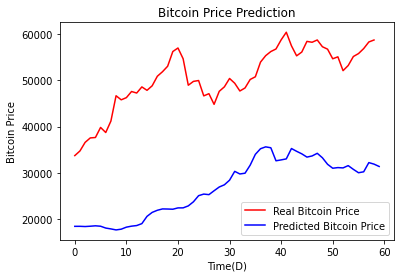

In [75]:
plt.plot(test_set.to_numpy(), color = 'red', label = 'Real Bitcoin Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time(D)')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()